In [32]:
import warnings
from functools import reduce
from operator import __add__
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from unsupervised_meta_learning.nn_utils import c_imshow
from unsupervised_meta_learning.pl_dataloaders import (UnlabelledDataModule,
                                                       UnlabelledDataset)
from unsupervised_meta_learning.proto_utils import (CAE, get_prototypes,
                                                    prototypical_loss)
from unsupervised_meta_learning.protoclr import ProtoCLR


In [2]:
kernel_sizes = (3, 3)
conv_padding = reduce(__add__, [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in kernel_sizes[::-1]])

class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_size=64, out_channels=64):
        super().__init__()

        self.encoder = nn.Sequential(
            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(in_channels, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14 x 14

            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7x7

            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2), #3x3

            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(hidden_size, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2), #1x1
            nn.Flatten()
        )
    def forward(self, inputs):
        return self.encoder(inputs)

class Decoder(nn.Module):
    def __init__(self, in_channels=1, hidden_size=64, out_channels=64):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(size=(4, 4)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),

            nn.UpsamplingNearest2d(size=(7, 7)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),

            nn.UpsamplingNearest2d(size=(14, 14)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),

            nn.UpsamplingNearest2d(size=(28, 28)),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding='same'),
            nn.BatchNorm2d(in_channels),
            nn.Sigmoid()
        )
    def forward(self, inputs):
        return self.decoder(inputs)
class AE(nn.Module):
    def __init__(self, in_channels=1, hidden_size=64, out_channels=64):
        super().__init__()

        self.encoder = Encoder(in_channels=in_channels, hidden_size=hidden_size, out_channels=out_channels)
        self.decoder = Decoder(in_channels=in_channels, hidden_size=hidden_size, out_channels=out_channels)

    def forward(self, inputs):
        print(inputs.shape)
        embeddings = self.encoder(inputs.view(-1, *inputs.shape[-3:]))
        print(embeddings.shape)
        recons = self.decoder(embeddings.unsqueeze(-1).unsqueeze(-1))
        return embeddings.view(*inputs.shape[:-3], -1), recons.view(*inputs.shape)

In [3]:
dataset_train = UnlabelledDataset(
    dataset='omniglot',
    datapath='./data/untarred/',
    split='train',
    n_support=1,
    n_query=3
)
dataloader_train = DataLoader(dataset_train,
                                      batch_size=50,
                                      shuffle=True,
                                      num_workers=8,
                                      pin_memory=torch.cuda.is_available())

In [4]:
x = next(iter(dataloader_train))

In [5]:
data = x['data'] # [batch_size x ways x shots x image_dim]

In [6]:
data = data.unsqueeze(0)

In [7]:
data.shape

torch.Size([1, 50, 4, 1, 28, 28])

In [8]:
batch_size = data.size(0)
ways = data.size(1)

In [9]:
batch_size, ways

(1, 50)

In [10]:
x_support = data[:,:,:1]
x_support = x_support.reshape((batch_size, ways * 1, *x_support.shape[-3:])) # e.g. [1,50*n_support,*(3,84,84)]
x_query = data[:,:,1:]
x_query = x_query.reshape((batch_size, ways * 3, *x_query.shape[-3:])) # e.g. [1,50*n_query,*(3,84,84)]

# Create dummy query labels
y_query = torch.arange(ways).unsqueeze(0).unsqueeze(2) # batch and shot dim
y_query = y_query.repeat(batch_size, 1, 1)
y_query = y_query.view(batch_size, -1).to('cuda')

y_support = torch.arange(ways).unsqueeze(0).unsqueeze(2) # batch and shot dim
y_support = y_support.repeat(batch_size, 1, 1)
y_support = y_support.view(batch_size, -1).to('cuda')

In [11]:
x_support.shape

torch.Size([1, 50, 1, 28, 28])

In [22]:
x_support[0][0].shape, x_query.reshape(1, x_support.shape[1], 3, 1, 28, 28)[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([3, 1, 28, 28]))

In [29]:
torch.vstack([x_support[0][0].unsqueeze(0), x_query.reshape(1, x_support.shape[1], 3, 1, 28, 28)[0][0]]).shape

torch.Size([4, 1, 28, 28])

In [33]:
img = make_grid(torch.vstack([x_support[0][0].unsqueeze(0), x_query.reshape(1, x_support.shape[1], 3, 1, 28, 28)[0][0]]))

In [34]:
import matplotlib.pyplot as plt

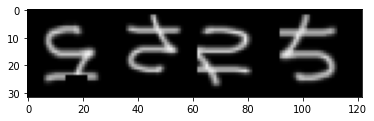

In [35]:
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [14]:
x_support[0][1].max()

tensor(0.9098)

In [18]:
F.dropout(x_support[0][1], p=.3).max()

tensor(1.2773)

In [24]:
enc = AE(1, 64, 64)

In [25]:
# Extract features (first dim is batch dim)
x = torch.cat([x_support, x_query], 1) # e.g. [1,50*(n_support+n_query),*(3,84,84)]
z, r = enc.forward(x)
z_support = z[:,:ways * 1] # e.g. [1,50*n_support,*(3,84,84)]
z_query = z[:,ways * 1:] # e.g. [1,50*n_query,*(3,84,84)]

r_supp = r[:,:ways * 1]
r_query = r[:,ways * 1:]

torch.Size([1, 200, 1, 28, 28])
torch.Size([200, 64])


In [26]:
z_support.shape

torch.Size([1, 50, 64])

In [27]:
r_supp.shape

torch.Size([1, 50, 1, 28, 28])

In [107]:
r_query.shape

torch.Size([1, 150, 1, 28, 28])

In [49]:
rs1 = r_supp.view(1, 50, 1, 1, 28, 28)[0][0]

In [52]:
rq1 = r_query.view(1, 50, 3, 1, 28, 28)[0][0]

In [88]:
F.mse_loss(rs1, rq1, reduction='none').sum()

/tmp/ipykernel_616/1915248140.py:1: UserWarning: Using a target size (torch.Size([3, 1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(rs1, rq1, reduction='none').sum()


tensor(6.7648e-10, grad_fn=<SumBackward0>)

In [81]:
a = (rs1[0]- rq1[0])

In [76]:
b = (rs1[0]- rq1[1])

In [78]:
c = (rs1[0]- rq1[2])

In [85]:
(a**2 + b ** 2+ c**2).sum(dim=[1,2])

tensor([6.7648e-10], grad_fn=<SumBackward1>)